In [4]:
# reload notebook
%load_ext autoreload
%autoreload 2
import jax 
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/changepoint_aug/density_estimation")
import pickle
import jax.numpy as jnp
import os
import haiku as hk
import matplotlib.animation as animation
from utils import load_maze_data
import pickle
import jax
import torch
import haiku as hk
import numpy as np
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from models import q_fn, vae_fn, decode_fn, get_prior_fn, policy_fn
from functools import partial
from changepoint_aug.density_estimation.configs.q_sarsa_config import get_config as get_q_config
from configs.vae_config import get_config as get_vae_config
from configs.bc_config import get_config as get_bc_config
from tensorflow_probability.substrates import jax as tfp
from pathlib import Path
dist = tfp.distributions
os.environ['CUDA_VISIBLE_DEVICES'] = '5'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load BC params

In [6]:
# get arbitary config 
bc_config = get_bc_config()
rng_key = jax.random.PRNGKey(0)

data_file = os.path.join(bc_config.data_dir, "sac_maze_dense_reward_200_episodes.pkl")

# load trained q model

model_base = "/scr/aliang80/changepoint_aug/changepoint_aug/ray_results/2_bc/train_model_fn_0dfa2_00001_1_num_trajs=10_2024-03-03_20-10-17"
model_file = Path(model_base) / "model_ckpts" / "epoch_190.pkl"

with open(model_file, "rb") as f:
    q_params = pickle.load(f)

print("loading q model from", model_file)

loading q model from /scr/aliang80/changepoint_aug/changepoint_aug/ray_results/2_bc/train_model_fn_0dfa2_00001_1_num_trajs=10_2024-03-03_20-10-17/model_ckpts/epoch_190.pkl


In [8]:
vae_config = get_vae_config()
rng_key = jax.random.PRNGKey(0)
# load trained q model
model_base = "/scr/aliang80/changepoint_aug/changepoint_aug/ray_results/3_vae/train_model_fn_9567a_00001_1_kl_div_weight=0.0100,seed=0_2024-03-03_20-42-43"
model_file = Path(model_base) / "model_ckpts" / "epoch_180.pkl"

with open(model_file, "rb") as f:
    vae_params = pickle.load(f)

In [12]:
# load dataset
dataset, train_dataloader, test_dataloader, obs_dim, action_dim = (
    load_maze_data(
        data_file,
        batch_size=bc_config.batch_size,
        num_trajs=500,
        train_perc=bc_config.train_perc
    )
)

# apply_q_fn = partial(hk.without_apply_rng(q_fn).apply, hidden_size=q_config.hidden_size)
apply_vae_fn = partial(vae_fn.apply, 
    latent_size=vae_config.latent_size,
    hidden_size=vae_config.hidden_size,
    obs_dim=2,
    cond_dim=2
)
apply_decode_fn = partial(hk.without_apply_rng(decode_fn).apply, 
    latent_size=vae_config.latent_size, 
    hidden_size=vae_config.hidden_size, 
    obs_dim=2, 
    cond_dim=2
)
apply_get_prior_fn = partial(hk.without_apply_rng(get_prior_fn).apply,
    latent_size=vae_config.latent_size,
    hidden_size=vae_config.hidden_size
)
policy_apply = partial(
    jax.jit(policy_fn.apply, static_argnums=(3, 4)),
    hidden_size=bc_config.hidden_size,
    action_dim=2,
)

def estimate_density(vae_params, rng_key, obs, goal, kl_div_weight, latent_size):
    vae_output = apply_vae_fn(vae_params, rng_key, obs, goal)

    # sample a bunch of z's from the posterior and decode them 
    # posterior is a normal distribution with mean and stddev
    # z = dist.Normal(0, 1)
    z = apply_get_prior_fn(vae_params, goal)
    num_posterior_samples = 100
    z_samples = z.sample(seed=rng_key, sample_shape=(num_posterior_samples,))    
    jax.debug.print(f"{z_samples.shape}")

    # decode conditioned on goal  
    obs_pred = jax.vmap(lambda z: apply_decode_fn(vae_params, z, goal))(z_samples)

    # repeat obs for each z sample
    obs = jnp.repeat(obs[None], num_posterior_samples, axis=0)

    # compute average l2 loss
    recon_loss = optax.squared_error(obs_pred, obs).sum(axis=-1).mean() 
    # jax.debug.print(f"{recon_loss.shape}")

    prior = dist.Normal(0, 1)
    posterior = dist.Normal(loc=vae_output.mean, scale=vae_output.stddev)
    kl_div_loss = dist.kl_divergence(posterior, prior).mean()
    # jax.debug.print(f"{kl_div_loss}")
    # jax.debug.print(f"{recon_loss}")

    # we want to maximize elbo
    # elbo = E[log p(x|z)] - KL[q(z|x) || p(z)]
    loss = recon_loss # + kl_div_weight * kl_div_loss
    elbo = -loss
    return elbo

number of rollouts:  200
average length of rollout:  310.295
obs_data shape:  torch.Size([61859, 6]) action_data shape:  torch.Size([61859, 2])
min obs data: torch.return_types.min(
values=tensor([-2.2135, -2.4461, -5.2254, -5.2262, -2.2330, -2.2267],
       dtype=torch.float64),
indices=tensor([12604, 14716, 43842,  7221,  9537, 12604])), max obs data: torch.return_types.max(
values=tensor([2.4332, 2.4417, 5.2260, 5.2398, 2.2458, 2.2462], dtype=torch.float64),
indices=tensor([38907, 38900,  4609, 36298, 27550, 43472]))
min action data: torch.return_types.min(
values=tensor([-0.9999, -1.0000]),
indices=tensor([ 9652, 16377])), max action data: torch.return_types.max(
values=tensor([0.9999, 0.9999]),
indices=tensor([16296,  9452]))
number of train batches:  434
number of test batches:  48


(87, 6) (87, 2) (87,)
(100, 8)


Text(0.5, 1.0, 'All trajectories + start and goal locations')

<Figure size 640x480 with 0 Axes>

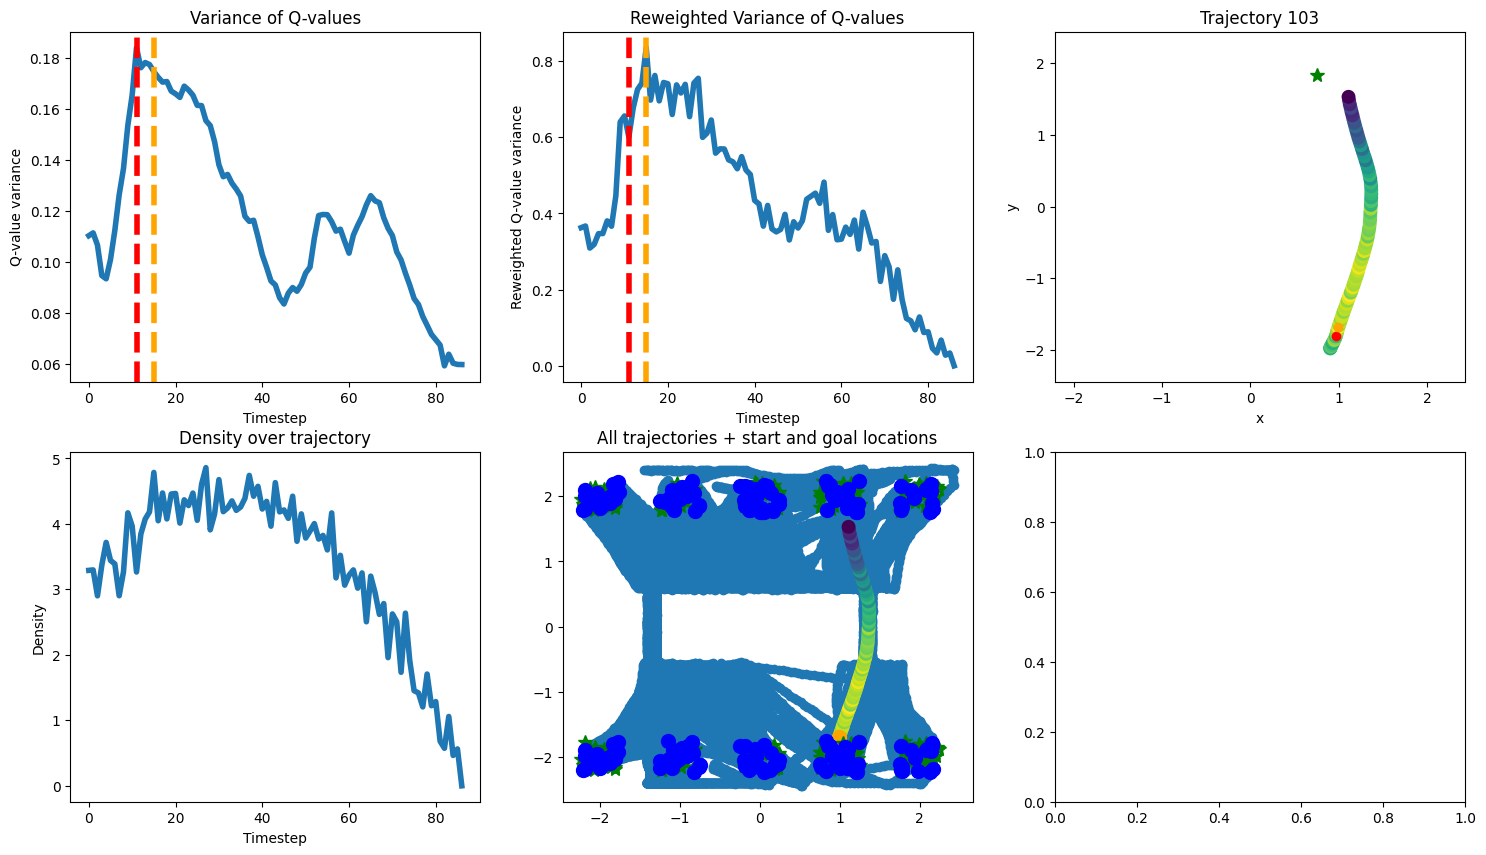

In [129]:
start_indices = np.where(dataset[:][-1])[0]
start_indices += 1
start_indices = np.insert(start_indices, 0, 0)
traj_indx = np.random.randint(0, len(start_indices) - 1)
# traj_indx = 6

start = start_indices[traj_indx]
end = start_indices[traj_indx + 1]

all_obss, all_actions, all_next_obss, all_next_actions, all_rewards, all_dones = dataset[:]

min_x = torch.min(all_obss[:, 0])
max_x = torch.max(all_obss[:, 0])
min_y = torch.min(all_obss[:, 1])
max_y = torch.max(all_obss[:, 1])

obss = all_obss[start:end].numpy()
actions = all_actions[start:end].numpy()
rewards = all_rewards[start:end].numpy()

print(obss.shape, actions.shape, rewards.shape)

plt.clf()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

T = np.arange(len(obss))
policy_apply = partial(
    jax.jit(policy_fn.apply, static_argnums=(3, 4)),
    hidden_size=bc_config.hidden_size,
    action_dim=2,
)
policy_rng_keys = jax.random.split(rng_key, bc_config.num_policies + 1)
action_preds = jax.vmap(lambda param, rng_key: policy_apply(param, rng_key, all_obss.numpy()))(
    q_params, policy_rng_keys[1:]
)
# compute variance between ensemble
all_variance = jnp.var(action_preds, axis=0)
variance = all_variance[start:end]

# compute mean over action dimension
variance = jnp.mean(variance, axis=-1)

# # compute q_values along that trajectory
# q_values = apply_q_fn(q_params, obss, actions)
# q_values = jnp.squeeze(q_values, axis=-1)
# print(q_values.shape)

# # first subplot plot the q_values and rewards
# axes[0].plot(T, q_values, label="Q-value", linewidth=4)
# axes[0].plot(T, rewards, label="Reward", linewidth=4)
# axes[0].legend()
# axes[0].set_xlabel("Timestep")
# axes[0].set_ylabel("Q-value")
# axes[0].set_title(f"Q-values for rollout {traj_indx}")

# # compute metric: var(Q(s, a+gaussian noise))
# num_samples = 100

# def apply_noise(params, state, action):
#     noise = jax.random.normal(rng_key, (num_samples, 2)) * 0.1
#     q = jax.vmap(lambda noise: apply_q_fn(params, state, action + noise))(noise)
#     return q

# def apply_action(params, states, actions):
#     q = jax.vmap(lambda state, action: apply_noise(params, state, action))(
#         states, actions
#     )
#     return q

# q = apply_action(q_params, obss, actions)
# q = jnp.squeeze(q, axis=-1)
# # [T, noise_samples]
# variance = jnp.var(q, axis=1)
# print(variance.shape)

axes[0].plot(T, variance, linewidth=4)
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Q-value variance")
axes[0].set_title("Variance of Q-values")


# plot the trajectory
traj_xy = obss[:, :2]
goal = obss[0, -2:]
rng_keys = jax.random.split(rng_key, all_obss.shape[0])
all_density = jax.vmap(
    lambda obs, key: estimate_density(vae_params, key, obs, goal, vae_config.kl_div_weight, vae_config.latent_size)
)(all_obss[:, :2].numpy(), rng_keys)

# reweight variance by density 
# scale density to be positive 
# all_density = all_density - np.min(all_density)
density = all_density[start:end]
density = density - np.min(density)
reweighted_variance = variance * density

axes[1].plot(T, reweighted_variance, linewidth=4)
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Reweighted Q-value variance")
axes[1].set_title("Reweighted Variance of Q-values")

axes[2].scatter(traj_xy[:, 0], traj_xy[:, 1], c=density, linewidth=4)
goal_location = dataset[start][0][-2:]
axes[2].plot(goal_location[0], goal_location[1], "g*", markersize=10)
axes[2].set_xlim(min_x, max_x)
axes[2].set_ylim(min_y, max_y)
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].set_title(f"Trajectory {traj_indx}")

# find location with max variance
max_var_idx = np.argmax(variance)

# max reweighted variance
max_rw_var_idx = np.argmax(reweighted_variance)

# set vline there
axes[0].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
axes[1].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
# make a point in axes[2]
max_var_point = obss[max_var_idx, :2]
axes[2].plot(max_var_point[0], max_var_point[1], "ro")

axes[0].axvline(x=max_rw_var_idx, color="orange", linestyle="--", linewidth=4)
axes[1].axvline(x=max_rw_var_idx, color="orange", linestyle="--", linewidth=4)
# make a point in axes[2]
max_rw_var_point = obss[max_rw_var_idx, :2]
axes[2].plot(max_rw_var_point[0], max_rw_var_point[1], color="orange", marker="o")

# plot density over trajectory 
axes[3].plot(T, density, linewidth=4)
axes[3].set_xlabel("Timestep")
axes[3].set_ylabel("Density")
axes[3].set_title("Density over trajectory")


# plot all of the trajectories
all_obss = dataset[:][0].numpy()
all_goal_locations = all_obss[start_indices[:-1], -2:]
all_start_locations = all_obss[start_indices[:-1], :2]
axes[4].scatter(all_obss[:, 0], all_obss[:, 1])
axes[4].scatter(traj_xy[:, 0], traj_xy[:, 1], c=density, linewidth=4)
axes[4].plot(max_var_point[0], max_var_point[1], "ro", markersize=10)
axes[4].plot(max_rw_var_point[0], max_rw_var_point[1], color="orange", marker="o", markersize=10)

axes[4].plot(all_goal_locations[:, 0], all_goal_locations[:, 1], "g*", markersize=10)
axes[4].plot(all_start_locations[:, 0], all_start_locations[:, 1], "bo", markersize=10)
axes[4].set_title("All trajectories + start and goal locations")

200
(61859, 2)
(161, 6)


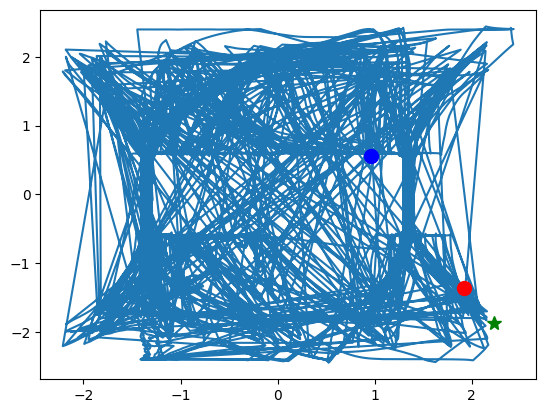

In [91]:
plt.clf()
# compute for each trajectory point with max variance
print(len(range(len(start_indices) - 1)))
print(all_variance.shape)

all_obss = dataset[:][0].numpy()
all_goal_locations = all_obss[start_indices[:-1], -2:]
all_start_locations = all_obss[start_indices[:-1], :2]
plt.plot(all_obss[:, 0], all_obss[:, 1])
# plt.plot(all_goal_locations[:, 0], all_goal_locations[:, 1], "g*", markersize=10)
# plt.plot(all_start_locations[:, 0], all_start_locations[:, 1], "bo", markersize=10)
# plt.set_title("All trajectories + start and goal locations")
# for i in range(len(start_indices) - 1):
# for i in range(3):
i = 6
start = start_indices[i]
goal = all_obss[start, -2:]
end = start_indices[i + 1]
obss = all_obss[start:end]
print(obss.shape)
var = all_variance[start:end]
# print(var.shape)
var = jnp.mean(var, axis=-1)

density = all_density[start:end]
density = density - np.min(density)
reweighted_variance = var * density

# top k 
k = 1
top_k_idx = jnp.argsort(var)[-k:]
top_k_points = obss[top_k_idx, :2]
plt.plot(top_k_points[:, 0], top_k_points[:, 1], "ro", markersize=10)
plt.plot(goal[0], goal[1], "g*", markersize=10)

k = 1
top_k_idx = jnp.argsort(reweighted_variance)[-k:]
top_k_points = obss[top_k_idx, :2]
plt.plot(top_k_points[:, 0], top_k_points[:, 1], "bo", markersize=10)
# axes[5].set_title("Trajectory with max variance")

In [ ]:
from collections import Counter
start_goal = all_obss[start_indices[:-1], -2:]
print(start_goal.shape)
Counter(start_goal.sum(axis=-1).tolist())
Counter(all_goal_locations.sum(axis=-1).tolist())

(100, 2)


Counter({0.21714340896865436: 999,
         4.308837197806755: 999,
         4.165924230834062: 999,
         1.958908693241645: 999,
         3.6730622004479376: 999,
         3.986351067352034: 999,
         4.135198212828259: 999,
         0.1346858664346735: 999,
         1.9682568325571312: 999,
         4.288305885045938: 600,
         4.410267337047719: 570,
         4.231309871976576: 490,
         3.6882585979758913: 477,
         4.048842200516791: 414,
         3.8733769614702416: 396,
         2.0281928253277424: 308,
         1.8073716783485634: 277,
         2.7781830932591616: 269,
         2.9925080073988672: 269,
         2.076058121131373: 229,
         1.1518863334461238: 223,
         1.6754330461069542: 217,
         1.1455363399461267: 209,
         1.9334255986112687: 209,
         0.6089973690138797: 206,
         0.8471553086870259: 204,
         1.914158999686661: 202,
         -0.3022329229412044: 200,
         -0.1101372449791298: 199,
         1.84286740624

In [51]:
vl_1 = ax1.axvline(x=0)
vl_2 = ax2.axvline(x=0)

def animate(i):
    vl_1.set_xdata([i, i])
    vl_2.set_xdata([i, i])
    traj_plot.set_data(xy[:i, 0], xy[:i, 1])

print("saving anim")
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

ani = animation.FuncAnimation(fig, animate, frames=T, interval=10, blit=True)
ani.save("movie.gif", fps=30, writer='imagemagick')

# %matplotlib notebook
# from IPython.display import HTML
# HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


saving anim
